# Client-Level Mean Reconstruction Attack & Utility Analysis

This notebook simulates a **client-level mean reconstruction attack** against a federated k-means algorithm. This attack is *different* from the data-point attack; its goal is to reconstruct the **mean of a client's entire dataset**.

The simulation is broken down into these steps:
1.  **Setup:** Import libraries and define all helper functions from the `gaussian_client.py` script.
2.  **Baseline Utility:** Train one full non-private model and one full private model (on all data) to measure their baseline k-means cost and accuracy. This demonstrates the **privacy-utility tradeoff**.
3.  **Load Attack Data:** Load the federated dataset that the attacker will use to select target clients.
4.  **Run Attack:** For `NUM_ATTACKS` iterations:
    a. Pick a random client to be the target.
    b. **Train a model *without* that target client** (once for private, once for non-private). This creates the `centers_baseline`.
    c. Simulate the target client's full update (`noisy_update_in`).
    d. The reconstructed client's total `(sum, count)` *is* this `noisy_update_in`.
    e. Calculate the reconstructed mean from the noisy sum and count.
    f. Compare the reconstructed mean to the true mean using **L2 Error** and **Cosine Similarity**.
5.  **Final Report:** Display the utility metrics and the attack metrics (with histograms) side-by-side.
6.  **Cleanup:** Remove all generated config and results files.

In [1]:
# --- 1. Setup & Imports ---

In [1]:
import subprocess
import os
import numpy as np
import yaml
import random
from sklearn.metrics import pairwise_distances
import sys
import math
import pickle 
import argparse # For Namespace object
from pathlib import Path
import matplotlib.pyplot as plt

# --- Add project root to path to ensure imports work ---
# This notebook assumes it is in 'reconstruction_attacks/'
# To run from 'fed-dp-kmeans-main/', change PROJECT_ROOT to "."
PROJECT_ROOT = ".." 
if PROJECT_ROOT not in sys.path:
    try:
        notebook_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        notebook_dir = os.path.abspath('')
    
    project_root_path = os.path.abspath(os.path.join(notebook_dir, PROJECT_ROOT))
    if project_root_path not in sys.path:
        print(f"Adding {project_root_path} to system path.")
        sys.path.insert(0, project_root_path)

# --- Import from project files ---
try:
    from data import make_data, set_data_args, add_data_arguments
    from utils import kmeans_cost, add_utils_arguments, set_seed, make_results_path
    from utils.argument_parsing import maybe_inject_arguments_from_config
    from pfl.data.sampling import get_user_sampler
    from pfl.data.federated_dataset import FederatedDataset
    from pfl.stats import MappedVectorStatistics
    from privacy.utils import get_mechanism
    from algorithms import add_algorithms_arguments
except ImportError as e:
    print(f"Error: {e}")
    print("Please ensure this notebook is in the 'reconstruction_attacks' directory,")
    print("or change the PROJECT_ROOT variable to point to the 'fed-dp-kmeans-main' directory.")

Adding /home/urvi/maml_project/Fed-DP-KMeans-and-MIA-Attack/fed-dp-kmeans-main to system path.


In [10]:
# --- Main Configuration ---

# Number of attack iterations (target clients).
NUM_ATTACKS = 20

# Global random seed for reproducibility.
SEED = 42

# Base config file to use for DP settings.
BASE_CONFIG_PATH = '../configs/gaussians_client_privacy.yaml'

In [4]:
# --- Helper Functions (From your gaussian_client.py script) ---

In [ ]:
def create_recon_configs(base_config_path='../configs/gaussians_client_privacy.yaml'):
    """Creates non-private and private config files based on a template."""
    try:
        with open(base_config_path, 'r') as f:
            base_config = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Warning: Base config file '{base_config_path}' not found. Using default Gaussian settings.")
        # Default settings similar to gaussians_client_privacy.yaml
        # base_config = {
        #     'dataset': 'GaussianMixtureUniform', 'K': 10, 'dim': 100,
        #     'num_train_clients': 100, 'samples_per_client': 1000,
        #     'samples_per_mixture_server': 20, 'num_uniform_server': 100,
        #     'initialization_algorithm': 'FederatedClusterInitExact', 
        #     'clustering_algorithm': 'FederatedLloyds',
        #     'minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1, # Run 1 iteration
        #     # Client-level privacy parameters
        #     'datapoint_privacy': False,
        #     'outer_product_epsilon': 1, 'weighting_epsilon': 1,
        #     'center_init_gaussian_epsilon': 1, 'center_init_contributed_components_epsilon': 0.2,
        #     'fedlloyds_epsilon': 1, 'fedlloyds_epsilon_split': 0.5,
        #     'outer_product_clipping_bound': 1500, 'weighting_clipping_bound': 1,
        #     'center_init_clipping_bound': 21, 'center_init_contributed_components_clipping_bound': 10,
        #     'fedlloyds_clipping_bound': 120, 'fedlloyds_laplace_clipping_bound': 50,
        #     'overall_target_delta': 1e-6,
        #     'fedlloyds_delta': 1e-6, # Make sure fedlloyds_delta is present
        #     'send_sums_and_counts': True # Assuming FedLloyds uses sums/counts
        # }
    except Exception as e:
        print(f"Error loading base config '{base_config_path}': {e}. Using default Gaussian settings.")
        # Use defaults as above
        # base_config = {
        #     'dataset': 'GaussianMixtureUniform', 'K': 10, 'dim': 100,
        #     'num_train_clients': 100, 'samples_per_client': 1000,
        #     'samples_per_mixture_server': 20, 'num_uniform_server': 100,
        #     'initialization_algorithm': 'FederatedClusterInit',
        #     'clustering_algorithm': 'FederatedLloyds',
        #     'minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1,
        #     'datapoint_privacy': False, 'outer_product_epsilon': 1, 'weighting_epsilon': 1,
        #     'center_init_gaussian_epsilon': 1, 'center_init_contributed_components_epsilon': 0.2,
        #     'fedlloyds_epsilon': 1, 'fedlloyds_epsilon_split': 0.5,
        #     'outer_product_clipping_bound': 1500, 'weighting_clipping_bound': 1,
        #     'center_init_clipping_bound': 21, 'center_init_contributed_components_clipping_bound': 10,
        #     'fedlloyds_clipping_bound': 120, 'fedlloyds_laplace_clipping_bound': 50,
        #     'overall_target_delta': 1e-6, 'fedlloyds_delta': 1e-6,
        #     'send_sums_and_counts': True
        # }


    # # Ensure necessary keys for get_mechanism('fedlloyds') are present
    base_config.setdefault('fedlloyds_num_iterations', 1)
    base_config.setdefault('fedlloyds_cohort_size', base_config.get('num_train_clients', 100)) # Default to all clients
    base_config.setdefault('num_train_clients', 100)
    base_config.setdefault('send_sums_and_counts', True) # Important for mechanism selection in get_mechanism
    base_config.setdefault('datapoint_privacy', False)
    base_config.setdefault('fedlloyds_epsilon', 1)
    base_config.setdefault('fedlloyds_epsilon_split', 0.5)
    # Ensure delta values are present and consistent
    default_delta = base_config.get('overall_target_delta', 1e-6)
    base_config.setdefault('overall_target_delta', default_delta)
    base_config.setdefault('fedlloyds_delta', default_delta) # Ensure fedlloyds_delta exists

    base_config.setdefault('fedlloyds_clipping_bound', 120)
    base_config.setdefault('fedlloyds_laplace_clipping_bound', 50)
    # Add defaults for the mean-sending alternative path in get_mechanism, even if unused
    base_config.setdefault('fedlloyds_contributed_components_epsilon', 0.2)
    base_config.setdefault('fedlloyds_contributed_components_clipping_bound', 10)

    os.makedirs("reconstruction_attacks/configs", exist_ok=True)

    # Config 1: Non-Private (Client Level)
    config_non_private = base_config.copy()
    config_non_private.update({
        'datapoint_privacy': False,
        'outer_product_privacy': False,
        'point_weighting_privacy': False,
        'center_init_privacy': False,
        'fedlloyds_privacy': False, # Explicitly turn off FedLloyds privacy
        'fedlloyds_num_iterations': 1
    })

    config_non_private_fname = 'reconstruction_attacks/configs/gaussian_client_non_private.yaml'
    with open(config_non_private_fname, 'w') as f:
        yaml.dump(config_non_private, f, sort_keys=False)

    # Config 2: Private (Client Level - using base config parameters)
    config_private = base_config.copy()
    config_private.update({
        'datapoint_privacy': False, # Client Level Attack
        'outer_product_privacy': True, # Keep other mechanisms on if needed by init algo
        'point_weighting_privacy': True,
        'center_init_privacy': True,
        'fedlloyds_privacy': True, # Explicitly turn on FedLloyds privacy (just in case)
        'fedlloyds_num_iterations': 1,
        'outer_product_epsilon': 1.5, 'weighting_epsilon': 1.5,
        'center_init_gaussian_epsilon': 1.5, 'fedlloyds_epsilon': 1.5

    })
    # Ensure fedlloyds_delta exists in the private config too
    config_private.setdefault('fedlloyds_delta', config_private.get('overall_target_delta', 1e-6))

    config_private_fname = 'reconstruction_attacks/configs/gaussian_client_private.yaml'
    with open(config_private_fname, 'w') as f:
        yaml.dump(config_private, f, sort_keys=False)

    print("Reconstruction attack config files created.")
    return config_non_private_fname, config_private_fname

def get_target_data(target_client_id_str, all_train_clients):
    """Fetches the raw data (X matrix) for the target client."""
    user_sampler = get_user_sampler('minimize_reuse', [target_client_id_str])
    target_dataset = FederatedDataset(all_train_clients.make_dataset_fn, user_sampler)
    (user_dataset, _) = next(target_dataset.get_cohort(1))
    # Ensure data is numpy array
    if hasattr(user_dataset.raw_data[0], 'numpy'): # Handle potential TensorFlow tensors
        return user_dataset.raw_data[0].numpy()
    return user_dataset.raw_data[0] # Return X (features)

# --- run_training_get_centers (For the attack) ---
def run_training_get_centers(config_file, exclude_client_id_str=None, seed=None):
    """Runs run.py for the attack (supports client exclusions)"""
    cmd = ['python', '../run.py', '--args_config', config_file]
    if exclude_client_id_str:
        cmd.extend(['--exclude_client_id_str', exclude_client_id_str])
    if seed is not None:
        cmd.extend(['--seed', str(seed)])

    print(f"\nRunning command: {' '.join(cmd)}")
    try:
        # Hide output for cleaner logs unless debugging
        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e:
        print(f"Error running training: {e}")
        return None
    except FileNotFoundError:
        print("Error: 'python' command not found. Make sure Python is in your PATH.")
        return None

    center_file = 'final_centers.npy'
    if not os.path.exists(center_file):
         print(f"Error: Center file '{center_file}' not found after running training.")
         return None
    return center_file

# --- run_main_training_for_utility (For baseline utility) ---
def run_main_training_for_utility(config_file, seed=None):
    """Runs run.py *without* exclusions to generate baseline utility metrics."""
    cmd = ['python', '../run.py', '--args_config', config_file]
    if seed is not None: cmd.extend(['--seed', str(seed)])
    print(f"\nRunning command for baseline utility: {' '.join(cmd)}")
    try: subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e: print(f"Error running baseline utility training: {e}"); return False
    except FileNotFoundError: print("Error: 'python' command not found."); return False
    return True

# --- get_baseline_utility ---
def get_baseline_utility(config_file, seed=None):
    """
    Runs main training once and fetches the cost/accuracy from its summary file.
    """
    success = run_main_training_for_utility(config_file, seed=seed)
    if not success:
        return np.nan, np.nan

    try:
        config_namespace = load_config_as_namespace(config_file)
    except Exception as e:
        print(f"Error loading config {config_file} to get results path: {e}")
        return np.nan, np.nan

    model_cost, model_accuracy = np.nan, np.nan
    try:
        privacy_type = 'data_point_level' if config_namespace.datapoint_privacy else 'client_level'
        results_path = make_results_path(privacy_type, config_namespace.dataset)
        summary_file = os.path.join(results_path, 'summary_results.pkl')
        
        if os.path.exists(summary_file):
            with open(summary_file, 'rb') as f:
                results_dict = pickle.load(f)
            final_results_key = 'Clustering' if 'Clustering' in results_dict else 'Initialization'
            if final_results_key in results_dict:
                model_cost = results_dict[final_results_key].get('Train client cost', np.nan)
                model_accuracy = results_dict[final_results_key].get('Train client accuracy', np.nan)
        else:
            print(f"  > Warning: Could not find summary file for utility: {summary_file}")
    except Exception as e:
        print(f"  > Error loading model metrics: {e}")
        
    return model_cost, model_accuracy

# Helper function to load config into an argparse-like namespace
def load_config_as_namespace(config_file):
    with open(config_file, 'r') as f:
        config_dict = yaml.safe_load(f)

    # --- Add ALL missing defaults that get_mechanism might expect ---
    config_dict.setdefault('num_train_clients', 100)
    config_dict.setdefault('send_sums_and_counts', True)
    config_dict.setdefault('center_init_send_sums_and_counts', False)
    config_dict.setdefault('datapoint_privacy', False)
    default_delta = config_dict.get('overall_target_delta', 1e-6)
    config_dict.setdefault('overall_target_delta', default_delta)
    config_dict.setdefault('fedlloyds_num_iterations', 1)
    config_dict.setdefault('fedlloyds_cohort_size', config_dict.get('num_train_clients', 100))
    config_dict.setdefault('fedlloyds_epsilon', 1.0)
    config_dict.setdefault('fedlloyds_epsilon_split', 0.5)
    config_dict.setdefault('fedlloyds_delta', default_delta)
    config_dict.setdefault('fedlloyds_clipping_bound', 120) 
    config_dict.setdefault('fedlloyds_laplace_clipping_bound', 50) 
    config_dict.setdefault('fedlloyds_contributed_components_epsilon', 0.2)
    config_dict.setdefault('fedlloyds_contributed_components_clipping_bound', 10)
    config_dict.setdefault('outer_product_epsilon', 1.0)
    config_dict.setdefault('outer_product_delta', default_delta)
    config_dict.setdefault('outer_product_clipping_bound', 1500)
    config_dict.setdefault('weighting_epsilon', 1.0)
    config_dict.setdefault('weighting_clipping_bound', 1)
    config_dict.setdefault('center_init_gaussian_epsilon', 1.0)
    config_dict.setdefault('center_init_delta', default_delta)
    config_dict.setdefault('center_init_epsilon_split', 0.5)
    config_dict.setdefault('center_init_clipping_bound', 21)
    config_dict.setdefault('center_init_laplace_clipping_bound', 1)
    config_dict.setdefault('center_init_contributed_components_epsilon', 0.2)
    config_dict.setdefault('center_init_contributed_components_clipping_bound', 10)
    # Add dataset for results path
    config_dict.setdefault('dataset', 'GaussianMixtureUniform')
    
    return argparse.Namespace(**config_dict)


def simulate_client_contribution(client_data, global_centers, config_namespace, seed=None):
    """
    Simulates the contribution (sums, counts) a client would send in FedLloyds,
    leveraging the project's existing privacy infrastructure.
    """
    K = global_centers.shape[0]
    dim = global_centers.shape[1]

    # 1. Assign points to centers
    if client_data.shape[0] == 0:
        raw_sums = np.zeros((K, dim), dtype=np.float32)
        raw_counts = np.zeros(K, dtype=np.float32)
    else:
        if client_data.dtype != global_centers.dtype:
             try:
                 client_data = client_data.astype(global_centers.dtype)
             except ValueError:
                 print("Warning: Client data type mismatch, attempting float32 cast.")
                 client_data = client_data.astype(np.float32)
                 global_centers = global_centers.astype(np.float32)

        dist_matrix = pairwise_distances(client_data, global_centers)
        assignments = np.argmin(dist_matrix, axis=1)

        # 2. Calculate true sums and counts
        raw_sums = np.zeros((K, dim), dtype=np.float32)
        raw_counts = np.zeros(K, dtype=np.float32)
        for k in range(K):
            mask = (assignments == k)
            if np.any(mask):
                raw_sums[k] = np.sum(client_data[mask], axis=0)
            raw_counts[k] = np.sum(mask)

    # 3. Create MappedVectorStatistics object
    raw_stats_dict = {}
    if config_namespace.send_sums_and_counts:
        raw_stats_dict['sum_points_per_component'] = raw_sums
        raw_stats_dict['num_points_per_component'] = raw_counts
    else:
        raw_stats_dict['contributed_components'] = (raw_counts > 0).astype(np.float32)
        safe_counts = np.where(raw_counts == 0, 1, raw_counts)
        raw_stats_dict['mean_points_per_component'] = raw_sums / safe_counts[:, np.newaxis]
    raw_stats = MappedVectorStatistics(raw_stats_dict)

    # 4. Instantiate the correct privacy mechanism
    mechanism_name = 'fedlloyds' if config_namespace.fedlloyds_privacy else 'no_privacy'
    try:
        if not hasattr(config_namespace, 'fedlloyds_delta'):
             config_namespace.fedlloyds_delta = config_namespace.overall_target_delta
        mechanism_wrapper = get_mechanism(config_namespace, mechanism_name)
        underlying_mechanism = mechanism_wrapper.underlying_mechanism
    except AttributeError as e:
        print(f"Error: Missing attribute in config_namespace for get_mechanism: {e}")
        raise
    except Exception as e:
        print(f"Error getting mechanism '{mechanism_name}': {e}")
        raise

    # 5. Apply Clipping
    try:
        simulated_seed_clipping = seed if seed is None else seed + 1
        clipped_stats, clip_metrics = underlying_mechanism.constrain_sensitivity(raw_stats, seed=simulated_seed_clipping)
    except Exception as e:
        print(f"Error during constrain_sensitivity: {e}")
        clipped_stats = raw_stats

    # 6. Apply DP Noise
    try:
        simulated_seed_noise = seed if seed is None else seed + 2
        noisy_stats, noise_metrics = underlying_mechanism.add_noise(clipped_stats, cohort_size=1, seed=simulated_seed_noise)
    except Exception as e:
        print(f"Error during add_noise: {e}")
        noisy_stats = clipped_stats

    # 7. Extract noisy results (FIXED PART)
    if config_namespace.send_sums_and_counts:
        if 'sum_points_per_component' in noisy_stats:
            final_noisy_sums = noisy_stats['sum_points_per_component']
        else:
            print("Warning: 'sum_points_per_component' not found in noisy_stats.")
            final_noisy_sums = np.zeros_like(raw_sums) # Default if key is missing

        if 'num_points_per_component' in noisy_stats:
            final_noisy_counts = noisy_stats['num_points_per_component']
        else:
            print("Warning: 'num_points_per_component' not found in noisy_stats.")
            final_noisy_counts = np.zeros_like(raw_counts) # Default if key is missing
    else:
         raise NotImplementedError("Reconstruction attack logic currently only supports 'send_sums_and_counts=True'")

    final_noisy_counts = np.maximum(0, final_noisy_counts)

    return final_noisy_sums, final_noisy_counts


def run_reconstruction_once(config_file, target_client_id_str, target_client_data, seed=None):
    """
    Runs one iteration of the reconstruction attack for a specific client.
    Returns (squared L2 error, cosine similarity) between true and reconstructed mean.
    """
    try:
        config_namespace = load_config_as_namespace(config_file)
        if not config_namespace.send_sums_and_counts:
            print(f"Error: Config file {config_file} needs send_sums_and_counts=True.")
            return np.nan, np.nan
    except Exception as e:
        print(f"Error loading config file {config_file}: {e}")
        return np.nan, np.nan

    # 1. Get Global Centers (Trained without the target client)
    print("Running training without target to get global centers...")
    centers_file = run_training_get_centers(config_file, exclude_client_id_str=target_client_id_str, seed=seed)
    if centers_file is None:
        print("Failed to obtain global centers. Skipping reconstruction for this client.")
        return np.nan, np.nan

    try:
        global_centers = np.load(centers_file)
    except Exception as e:
        print(f"Error loading centers file {centers_file}: {e}")
        if os.path.exists(centers_file): os.remove(centers_file)
        return np.nan, np.nan
    finally:
        if os.path.exists(centers_file): os.remove(centers_file) # Clean up

    # 2. Simulate the target client's contribution (potentially noisy)
    print(f"Simulating contribution for client {target_client_id_str}...")
    try:
        sim_seed = seed + 100 if seed is not None else None
        noisy_sums, noisy_counts = simulate_client_contribution(target_client_data, global_centers, config_namespace, seed=sim_seed)
    except Exception as e:
        print(f"Error simulating client contribution: {e}")
        return np.nan, np.nan

    # 3. Reconstruct the mean from the noisy contribution
    total_noisy_sum = np.sum(noisy_sums, axis=0)
    total_noisy_count = np.sum(noisy_counts)
    
    error = np.nan
    cosine_sim = np.nan

    if total_noisy_count <= 1e-9:
        print("Warning: Total noisy count is near zero. Reconstruction failed.")
    else:
        reconstructed_mean = total_noisy_sum / total_noisy_count
        true_mean = np.mean(target_client_data, axis=0)

        if not np.isnan(reconstructed_mean).any():
            # 4. Calculate L2 Error
            error = np.sum((true_mean - reconstructed_mean)**2)
             
            # 5. Calculate Cosine Similarity
            norm1 = np.linalg.norm(true_mean)
            norm2 = np.linalg.norm(reconstructed_mean)
            if norm1 > 1e-9 and norm2 > 1e-9:
                cosine_sim = np.dot(true_mean, reconstructed_mean) / (norm1 * norm2)
            elif norm1 < 1e-9 and norm2 < 1e-9:
                cosine_sim = 1.0 # Both zero vectors
            else:
                cosine_sim = 0.0 # One is zero

            print(f"Target {target_client_id_str}: True Mean Norm={norm1:.4f}, Recon Mean Norm={norm2:.4f}, Sq L2 Error={error:.6f}, Cosine Sim={cosine_sim:.6f}")
        else:
             print(f"Target {target_client_id_str}: Reconstruction resulted in NaN values.")

    return error, cosine_sim

## Step 1: Initialization

Set the global seed and create the two `.yaml` config files for **client-level** privacy.

In [12]:
if SEED is not None:
    set_seed(SEED)
    print(f"Set global seed to {SEED}")

# --- Setup ---
print("--- 1. Creating Reconstruction Attack config files ---")
try:
    config_non_private_file, config_private_file = create_recon_configs(BASE_CONFIG_PATH)
    print(f"Non-private config: {config_non_private_file}")
    print(f"Private config: {config_private_file}")
except Exception as e:
    print(f"Fatal Error: Could not create config files. {e}")

Set global seed to 42
--- 1. Creating Reconstruction Attack config files ---
Reconstruction attack config files created.
Non-private config: reconstruction_attacks/configs/gaussian_client_non_private.yaml
Private config: reconstruction_attacks/configs/gaussian_client_private.yaml


## Step 2: Calculate Baseline Model Utility (Privacy-Utility Tradeoff)

Run the full training process (with no clients excluded) once for each config to get the baseline k-means cost and accuracy.

In [13]:
print("--- 2. Calculating Baseline Model Utility (this may take a moment) ---")
utility_metrics = {}

if 'config_non_private_file' in locals():
    print("  Running NON-PRIVATE model...")
    cost_np, acc_np = get_baseline_utility(config_non_private_file, seed=SEED)
    utility_metrics['non_private'] = {'cost': cost_np, 'accuracy': acc_np}

    print("  Running PRIVATE model...")
    cost_p, acc_p = get_baseline_utility(config_private_file, seed=SEED)
    utility_metrics['private'] = {'cost': cost_p, 'accuracy': acc_p}
else:
    print("Skipping utility calculation because config files were not created.")
    utility_metrics['non_private'] = {'cost': np.nan, 'accuracy': np.nan}
    utility_metrics['private'] = {'cost': np.nan, 'accuracy': np.nan}

--- 2. Calculating Baseline Model Utility (this may take a moment) ---
  Running NON-PRIVATE model...

Running command for baseline utility: python ../run.py --args_config reconstruction_attacks/configs/gaussian_client_non_private.yaml --seed 42
  Running PRIVATE model...

Running command for baseline utility: python ../run.py --args_config reconstruction_attacks/configs/gaussian_client_private.yaml --seed 42


## Analysis: Privacy vs. Utility

Here are the baseline utility metrics for the **client-level** models. Unlike the data-point-level case, we now expect to see a clearer tradeoff, where the non-private model has better utility (lower cost, higher accuracy).

In [15]:
print("\n--- BASELINE PRIVACY-UTILITY TRADEOFF ---")
print(f"  NON-PRIVATE: Cost = {utility_metrics['non_private']['cost']:.6f}, Accuracy = {utility_metrics['non_private']['accuracy']:.6f}")
print(f"  PRIVATE:     Cost = {utility_metrics['private']['cost']:.6f}, Accuracy = {utility_metrics['private']['accuracy']:.6f}")
print("---------------------------------------------")


--- BASELINE PRIVACY-UTILITY TRADEOFF ---
  NON-PRIVATE: Cost = 49.948333, Accuracy = 0.984860
  PRIVATE:     Cost = 50.373482, Accuracy = 0.980960
---------------------------------------------


## Step 3: Load Client Data for Attack

Now, we load the full federated dataset to get the list of clients we can attack.

In [16]:
print("\n--- 3. Loading client list (Gaussian Dataset) ---")
all_client_ids = []
if 'config_non_private_file' in locals():
    temp_parser = argparse.ArgumentParser(add_help=False)
    temp_parser = add_data_arguments(temp_parser)
    temp_parser = add_utils_arguments(temp_parser)
    temp_parser = add_algorithms_arguments(temp_parser)

    original_argv = sys.argv.copy()
    # Temporarily modify sys.argv for maybe_inject_arguments_from_config
    sys.argv = [sys.argv[0], '--args_config', config_non_private_file]
    maybe_inject_arguments_from_config()

    try:
        data_args, _ = temp_parser.parse_known_args()
        if SEED is not None:
            data_args.data_seed = SEED
        set_data_args(data_args) # Sets num_train_clients etc.
        
        # Load all training clients
        data_args.exclude_client_id_str = None
        all_train_clients, _, _, _ = make_data(data_args)
        all_client_ids = [str(i) for i in range(data_args.num_train_clients)]
        print(f"Loaded {len(all_client_ids)} total clients.")
        
    except Exception as e:
         print(f"Fatal Error: Could not load data using config '{config_non_private_file}'. Check data paths and parameters. Error: {e}")
         print("Data Args used:", data_args)
    finally:
        sys.argv = original_argv # Restore
else:
    print("Skipping data loading because config files were not created.")
    

num_attacks_to_run = 0
if all_client_ids:
    num_attacks_to_run = min(NUM_ATTACKS, len(all_client_ids))
    if num_attacks_to_run <= 0:
        num_attacks_to_run = 1 
    print(f"Will run reconstruction attack on {num_attacks_to_run} random clients.")
else:
     print("Error: No clients loaded. Cannot run attacks.")


--- 3. Loading client list (Gaussian Dataset) ---
Final Server Dataset Size: 300 samples
Loaded 2000 total clients.
Will run reconstruction attack on 20 random clients.


## Step 4: Run the Reconstruction Attack

This is the main attack loop. We will iterate `num_attacks_to_run` times, picking a new random client each time and attempting to reconstruct its **mean vector**.

In [17]:
config_non_private_file, config_private_file = create_recon_configs(BASE_CONFIG_PATH)
print(f"\n--- 4. Starting Client-Level Reconstruction Attack for {num_attacks_to_run} clients ---")

results = {
    'non_private': {'errors': [], 'cosine_sims': []},
    'private': {'errors': [], 'cosine_sims': []}
}
config_files = {
    'non_private': config_non_private_file,
    'private': config_private_file
}

if num_attacks_to_run > 0:
    # Sample target clients without replacement
    rng = np.random.default_rng(SEED)
    if num_attacks_to_run >= len(all_client_ids):
        target_clients_sample = all_client_ids
    else:
        target_clients_sample = rng.choice(all_client_ids, size=num_attacks_to_run, replace=False).tolist()

    for i, target_client_id in enumerate(target_clients_sample):
        print(f"\n--- ATTACK ITERATION {i+1} / {num_attacks_to_run} ---")
        print(f"Target Client: {target_client_id}")

        try:
            target_data = get_target_data(target_client_id, all_train_clients)
            if target_data.shape[0] == 0:
                print("Target client has no data. Skipping.")
                continue
            print(f"Target data loaded. Shape: {target_data.shape}")
        except StopIteration:
            print(f"Error: Could not sample target client {target_client_id}. Skipping.")
            continue
        except Exception as e:
            print(f"Error loading data for client {target_client_id}: {e}")
            continue

        for mode in ['non_private', 'private']:
            print(f"--- Running {mode.upper()} scenario ---")
            config_file = config_files[mode]
            iter_seed = (SEED + i*10 + (0 if mode == 'non_private' else 1)) if SEED is not None else None

            try:
                error, cos_sim = run_reconstruction_once(config_file, target_client_id, target_data, seed=iter_seed)
                if not np.isnan(error):
                    results[mode]['errors'].append(error)
                    results[mode]['cosine_sims'].append(cos_sim)
                else:
                    print(f"Reconstruction failed for client {target_client_id} in {mode} mode (NaN error).")

            except Exception as e:
                print(f"Attack failed for {mode} on client {target_client_id} due to unexpected error: {e}")
                import traceback
                traceback.print_exc()
else:
    print("Skipping attack loop as no clients were loaded.")

Reconstruction attack config files created.

--- 4. Starting Client-Level Reconstruction Attack for 20 clients ---

--- ATTACK ITERATION 1 / 20 ---
Target Client: 1533
Target data loaded. Shape: (50, 100)
--- Running NON_PRIVATE scenario ---
Running training without target to get global centers...

Running command: python ../run.py --args_config reconstruction_attacks/configs/gaussian_client_non_private.yaml --exclude_client_id_str 1533 --seed 42
Simulating contribution for client 1533...
Target 1533: True Mean Norm=5.2574, Recon Mean Norm=5.2574, Sq L2 Error=0.000000, Cosine Sim=1.000000
--- Running PRIVATE scenario ---
Running training without target to get global centers...

Running command: python ../run.py --args_config reconstruction_attacks/configs/gaussian_client_private.yaml --exclude_client_id_str 1533 --seed 43
Simulating contribution for client 1533...
Target 1533: True Mean Norm=5.2574, Recon Mean Norm=130.1088, Sq L2 Error=17158.853425, Cosine Sim=-0.148327

--- ATTACK IT

## Step 5: Final Results & Analysis

Here is the final report. 

We can see the **Model Utility** (Cost/Accuracy) at the top, followed by the **Reconstruction Attack Metrics** (L2 Error/Cosine Similarity) for the *client mean*.

In [18]:
print("\n--- FINAL CLIENT MEAN RECONSTRUCTION RESULTS ---")

print("\n--- Model Utility (Privacy-Utility Tradeoff) ---")
print(f"  NON-PRIVATE: Cost = {utility_metrics['non_private']['cost']:.6f}, Accuracy = {utility_metrics['non_private']['accuracy']:.6f}")
print(f"  PRIVATE:     Cost = {utility_metrics['private']['cost']:.6f}, Accuracy = {utility_metrics['private']['accuracy']:.6f}")

print("\n--- Reconstruction Attack Metrics (Client Mean) ---")
for mode in ['non_private', 'private']:
    res = results[mode]
    count = len(res['errors'])
    if count > 0:
        print(f"\n{mode.upper()} Model Results ({count} clients):")
        
        # Reconstruction Error
        errors = res['errors']
        avg_error=np.nanmean(errors); std_error=np.nanstd(errors); median_error=np.nanmedian(errors)
        print(f"  Reconstruction Sq L2 Error:")
        print(f"    Avg: {avg_error:.6f}, StdDev: {std_error:.6f}, Median: {median_error:.6f}")

        # Cosine Similarity
        sims = res['cosine_sims']
        avg_sim=np.nanmean(sims); std_sim=np.nanstd(sims); median_sim=np.nanmedian(sims)
        print(f"  Reconstruction Cosine Similarity:")
        print(f"    Avg: {avg_sim:.6f}, StdDev: {std_sim:.6f}, Median: {median_sim:.6f}")
    else: 
        print(f"\n{mode.upper()} Model: No successful attacks.")


--- FINAL CLIENT MEAN RECONSTRUCTION RESULTS ---

--- Model Utility (Privacy-Utility Tradeoff) ---
  NON-PRIVATE: Cost = 49.948333, Accuracy = 0.984860
  PRIVATE:     Cost = 50.373482, Accuracy = 0.980960

--- Reconstruction Attack Metrics (Client Mean) ---

NON_PRIVATE Model Results (20 clients):
  Reconstruction Sq L2 Error:
    Avg: 0.000000, StdDev: 0.000000, Median: 0.000000
  Reconstruction Cosine Similarity:
    Avg: 1.000000, StdDev: 0.000000, Median: 1.000000

PRIVATE Model Results (20 clients):
  Reconstruction Sq L2 Error:
    Avg: 10439.344089, StdDev: 21159.680669, Median: 3367.610088
  Reconstruction Cosine Similarity:
    Avg: 0.009794, StdDev: 0.110445, Median: 0.024432


### Plotting the Distributions (Histograms)

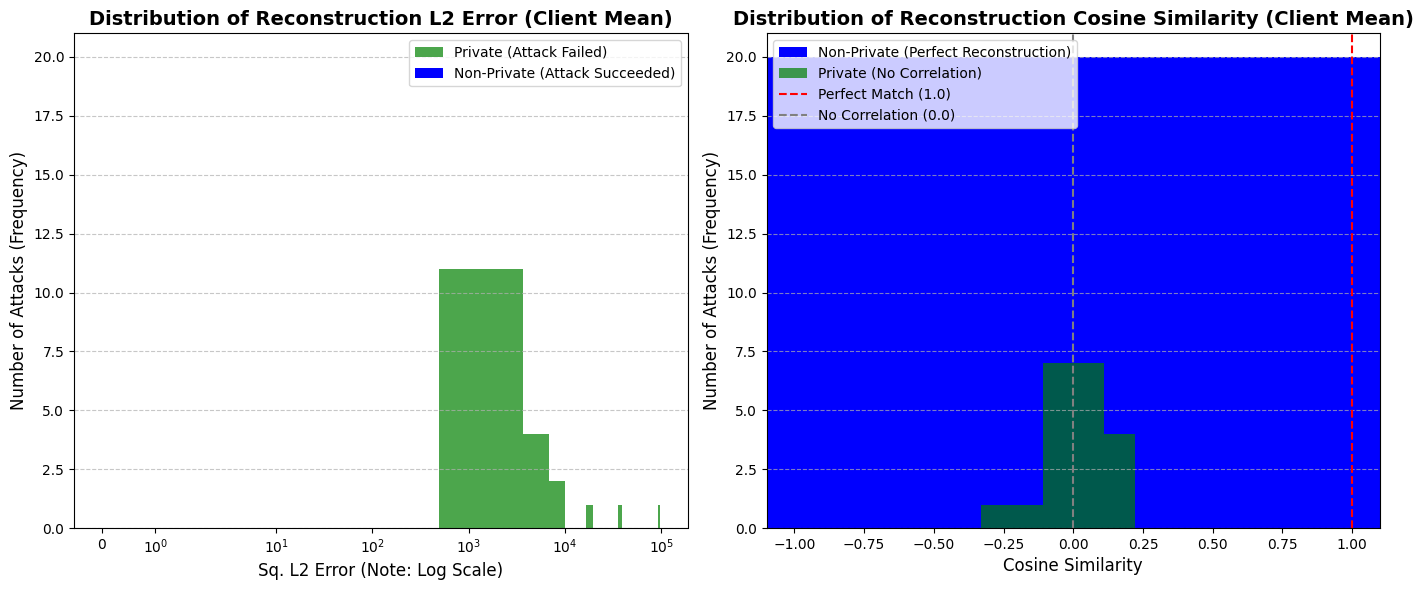

In [ ]:
colors = ["blue", "green"]

plt.figure(figsize=(14, 6))

# --- Plot 1: L2 Error Histogram --- 
plt.subplot(1, 2, 1)
if results['private']['errors']:
    plt.hist(results['private']['errors'], bins=30, alpha=0.7, color=colors[1], label='Private (Attack Failed)')
if results['non_private']['errors']:
    plt.hist(results['non_private']['errors'], bins=1, alpha=1.0, color=colors[0], label='Non-Private (Attack Succeeded)')

plt.title('Distribution of Reconstruction L2 Error (Client Mean)', fontsize=14, fontweight='bold')
plt.xlabel('Sq. L2 Error (Note: Log Scale)', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xscale('symlog') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# --- Plot 2: Cosine Similarity Histogram --- 
plt.subplot(1, 2, 2)
if results['non_private']['cosine_sims']:
    plt.hist(results['non_private']['cosine_sims'], bins=1, range=(-1.1, 1.1), alpha=1.0, color=colors[0], label='Non-Private (Perfect Reconstruction)')
if results['private']['cosine_sims']:
    plt.hist(results['private']['cosine_sims'], bins=20, range=(-1.1, 1.1), alpha=0.7, color=colors[1], label='Private (No Correlation)')

plt.title('Distribution of Reconstruction Cosine Similarity (Client Mean)', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xlim(-1.1, 1.1)

# Add reference lines for clarity
plt.axvline(1.0, color='red', linestyle='--', label='Perfect Match (1.0)')
plt.axvline(0.0, color='grey', linestyle='--', label='No Correlation (0.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

### Final Analysis

**Client-level DP** is a *weaker* guarantee than data-point-level DP. It only promises to hide the participation of an *entire client*, not a single data point within that client.

This attack attempts to reconstruct the *mean* of the entire client's dataset. 

* **Non-Private:** The L2 Error should be very low (near 0) and Cosine Similarity should be very high (near 1.0). The attacker can perfectly reconstruct the client's mean statistics.

* **Private (Client-Level):** The L2 Error should be *higher* than the non-private case, and the Cosine Similarity *lower*. Because the noise is calibrated to hide the *whole client*, the reconstruction of the client's mean should be significantly distorted. The histograms will show how much this distortion varies across different clients.

## Step 6: Cleanup

Finally, we remove all the temporary config files, model center files (`.npy`), and results files (`.pkl`) created during the run.

In [23]:
print("\n--- 6. Cleaning up generated files... ---")
try:
    if 'config_non_private_file' in locals() and os.path.exists(config_non_private_file): 
        os.remove(config_non_private_file)
        print(f"Removed {config_non_private_file}")
    if 'config_private_file' in locals() and os.path.exists(config_private_file): 
        os.remove(config_private_file)
        print(f"Removed {config_private_file}")
    if os.path.exists('final_centers.npy'): 
        os.remove('final_centers.npy')
        print("Removed final_centers.npy")
        
    # Clean up utility results files
    if 'config_non_private_file' in locals():
        for cfg_file in [config_non_private_file, config_private_file]:
            try:
                ns = load_config_as_namespace(cfg_file) # Config file might be deleted, load from memory
                ptype = 'data_point_level' if ns.datapoint_privacy else 'client_level'
                rpath = make_results_path(ptype, ns.dataset)
                sfile = os.path.join(rpath, 'summary_results.pkl')
                if os.path.exists(sfile): 
                    os.remove(sfile)
                    print(f"Removed {sfile}")
            except Exception as e:
                print(f"Note: Could not clean up summary file for {cfg_file}. It may already be gone. {e}")
            
    print("Cleanup complete.")
except OSError as e: 
    print(f"Error during cleanup: {e}")


--- 6. Cleaning up generated files... ---
Removed reconstruction_attacks/configs/gaussian_client_non_private.yaml
Removed reconstruction_attacks/configs/gaussian_client_private.yaml
Note: Could not clean up summary file for reconstruction_attacks/configs/gaussian_client_non_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'reconstruction_attacks/configs/gaussian_client_non_private.yaml'
Note: Could not clean up summary file for reconstruction_attacks/configs/gaussian_client_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'reconstruction_attacks/configs/gaussian_client_private.yaml'
Cleanup complete.


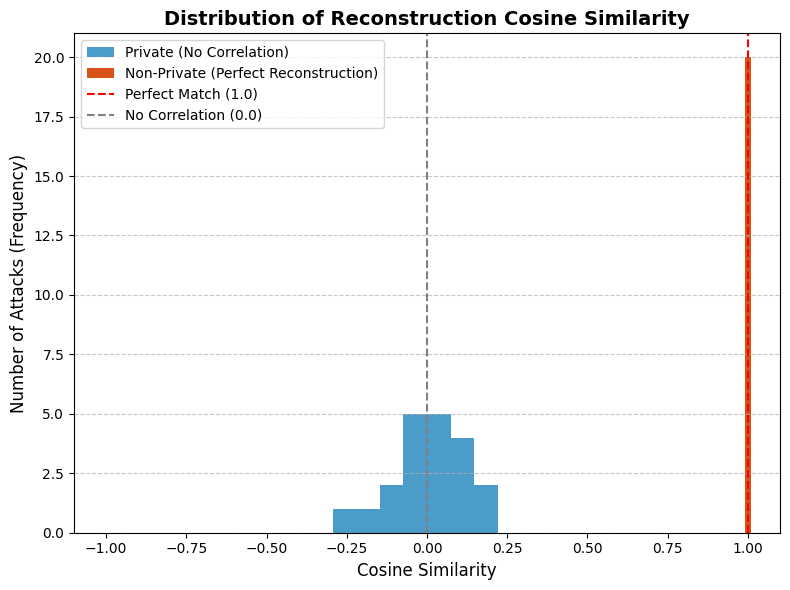

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import re
from io import StringIO


    

# --- 3. Plotting Code ---
colors = ['#D95319', '#0072B2'] # (Red/Orange, Blue)

plt.figure(figsize=(8, 6)) # Single plot size

# ======================================================================
# Plot: Cosine Similarity Distribution (Using extracted 'results') 📐
# ======================================================================

# Plot private (clustered around 0.0) with more bins for better detail
plt.hist(
    results['private']['cosine_sims'], 
    bins=30, 
    range=(-1.1, 1.1), 
    alpha=0.7, 
    color=colors[1], 
    label='Private (No Correlation)'
)

# Plot non-private (all at 1.0) using a very narrow custom bin to create a sharp bar
non_private_bins = [0.99, 1.01] # Creates a single bin centered at 1.0
plt.hist(
    results['non_private']['cosine_sims'], 
    bins=non_private_bins, 
    alpha=1.0, 
    color=colors[0], 
    label='Non-Private (Perfect Reconstruction)'
)

plt.title('Distribution of Reconstruction Cosine Similarity', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xlim(-1.1, 1.1)

# Add reference lines for clarity
plt.axvline(1.0, color='red', linestyle='--', label='Perfect Match (1.0)')
plt.axvline(0.0, color='grey', linestyle='--', label='No Correlation (0.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()

# --- Save the Figure ---
plt.savefig('reconstruction_attack_results_client.png', dpi=300) 
plt.show()